**Square IC Training**

This file explores a similar procedure to what is shown in the plane_IC case, but with data from the square soruce. Although explored in less detail, initial results seem to indicate that this slightly more complicated problem can be solved more accurately by the neural network.

This may indicate that with increasingly complex problems, not only would the merits of using machine learning increase, but the accuracy might as well. This may indicate utility in the extremely large compute times requires to create both the metadata to train the model, and the training of the model itself.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 15 15:46:03 2023

@author: thomasking
"""

## plane_ic structure
# keys are times
# solution matrix contains
# 0 - xs
# 1 - phi (solution)
# 2 - uncollided solution

# plane_IC contions
# 0 - t
# 1 - x0 or sigma
# 2 - c (scattering ratio)

import h5py
import numpy as np
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

f = h5py.File('square_IC2.hdf5')
g = h5py.File('square_IC_conditions2.hdf5')



keysF= []
keysG = []
valuesF = []
valuesG = []
solv1 = []
solv2 = []
solv3 = []
iv1 = []
iv2 = []
iv3 = []




itemsF = f['square_IC'].items()
itemsG = g['square_IC'].items()


for itemF in itemsF:
    keysF.append(itemF[0]), valuesF.append(itemF[1])
for itemG in itemsG:
    keysG.append(itemG[0]), valuesG.append(itemG[1])

for i in range(len(keysF)):
    solv1.append(valuesF[i][0])
    solv2.append(valuesF[i][1])
    solv3.append(valuesF[i][2])

for i in range(len(keysG)):
    iv1.append(valuesG[i][0])
    iv2.append(valuesG[i][1])
    iv3.append(valuesG[i][2])

solv1 = np.array(solv1)
solv2 = np.array(solv2)
solv3 = np.array(solv3)
iv1 = np.squeeze(np.array(iv1))
iv2 = np.squeeze(np.array(iv2))
iv3 = np.squeeze(np.array(iv3))

tpnts, npnts = solv1.shape
npntsv = np.linspace(npnts, npnts, tpnts)
#npntsvn = npntsv/np.linalg.norm(npntsv)

#get initial conditon vectors
ics = np.array([iv1,iv2, iv3])
ics = ics.transpose()
ics_norm = normalize(ics, norm='l2')
sols = solv2 #[:,0:1]
sols_norm = normalize(sols, norm='l2')





x_train, x_test, y_train, y_test = train_test_split(ics_norm, sols_norm, test_size = 0.2)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(6, activation ='gelu', input_dim = 3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(12, activation = 'gelu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation ='gelu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(250, activation ='linear'))
#model.add(tf.keras.layers.Dense(100, activation ='gelu'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dense(1000, activation ='linear'))
model.build()
model.summary()


# phsycial - the sum of the points, integral of solution always = e^(-t*(1/2-c))

# can make the sum of y_pred = sum of y_true to accomplish this

def custom_loss_function(y_true, y_pred):
  #vals = tf.math.less(y_pred, 0)
  loss = tf.cond(tf.math.less(tf.math.reduce_min(y_pred), 0), lambda: float(10**6) * tf.square(y_true - y_pred), lambda: (0.06) * tf.square(tf.math.reduce_sum(y_pred) - tf.math.reduce_sum(y_true)) + tf.square(y_true - y_pred))
  #loss = tf.cond(tf.math.less(tf.math.reduce_min(y_pred), 0), lambda: float(10**6) * tf.square(y_true - y_pred), lambda: tf.square(y_true - y_pred))
  return tf.reduce_mean(loss, axis=-1)

#test_pred = model.predict(x_train)
#print(test_pred.shape)
#test_loss = custom_loss_function(y_train, test_pred)
#print(test_loss)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 batch_normalization (Batch  (None, 6)                 24        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 batch_normalization_1 (Bat  (None, 12)                48        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                832       
                                                                 
 batch_normalization_2 (Bat  (None, 64)                2

In [ ]:

model.compile(optimizer='adam', loss=custom_loss_function , metrics = ['mae'])
model.fit(x_train, y_train, verbose = 1, epochs = 500, validation_data = (x_test, y_test))

Epoch 1/500
125/125 [==============================] - 6s 8ms/step - loss: 48054.4141 - mae: 0.1276 - val_loss: 3395.6562 - val_mae: 0.0462
Epoch 2/500
125/125 [==============================] - 0s 3ms/step - loss: 3926.1104 - mae: 0.0424 - val_loss: 5682.7832 - val_mae: 0.0579
Epoch 3/500
125/125 [==============================] - 0s 3ms/step - loss: 1978.8313 - mae: 0.0308 - val_loss: 6955.2666 - val_mae: 0.0639
Epoch 4/500
125/125 [==============================] - 0s 3ms/step - loss: 1347.8253 - mae: 0.0255 - val_loss: 3990.6033 - val_mae: 0.0493
Epoch 5/500
125/125 [==============================] - 0s 3ms/step - loss: 940.1306 - mae: 0.0213 - val_loss: 1582.7596 - val_mae: 0.0298
Epoch 6/500
125/125 [==============================] - 0s 3ms/step - loss: 746.4556 - mae: 0.0190 - val_loss: 770.1556 - val_mae: 0.0199
Epoch 7/500
125/125 [==============================] - 0s 4ms/step - loss: 645.6791 - mae: 0.0176 - val_loss: 565.5137 - val_mae: 0.0167
Epoch 8/500
125/125 [==========

In [ ]:

#run model
yhat = model.predict(ics_norm)

157/157 [==============================] - 0s 2ms/step


t = 5.626304 x0 =  12.198165 c =  0.7404844


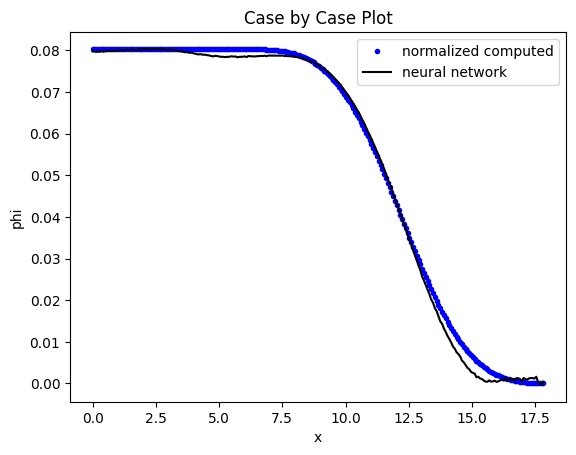

In [ ]:
import matplotlib.pyplot as plt


rows, cols = sols.shape


#plot case by case

#enter a test case (0-999)
tcase = 4562

plt.figure(1)
plt.title("Case by Case Plot")
plt.plot(solv1[tcase, :], sols_norm[tcase] , 'b.', label = "normalized computed")
#plt.plot(solv1[tcase, :], sols[tcase] , 'r.', label = "not normal")
print('t =', iv1[tcase], 'x0 = ', iv2[tcase], 'c = ', iv3[tcase])
plt.plot(solv1[tcase, :], yhat[tcase, :] , 'k-', label = "neural network")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend(loc="best")
plt.show()


In [ ]:
model.save("square_IC_model.h5")
model.save("square_IC_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# plane IC Model Testing

# model based on data from [0, 50] c [0.6, 1.4] x0 [0 20] mae=.005
def custom_loss_function(y_true, y_pred):
  loss = tf.cond(tf.math.less(tf.math.reduce_min(y_pred), 0), lambda: float(10**6) * tf.square(y_true - y_pred), lambda: (0.1) * tf.square(tf.math.reduce_sum(y_pred) - tf.math.reduce_sum(y_true)) + tf.square(y_true - y_pred))
  return tf.reduce_mean(loss, axis=-1)

from keras.models import load_model
model = load_model('square_IC_model.h5', custom_objects={'custom_loss_function': custom_loss_function})

#lets try a sample of test cases the model has not seen yet


1/1 [==============================] - 0s 94ms/step


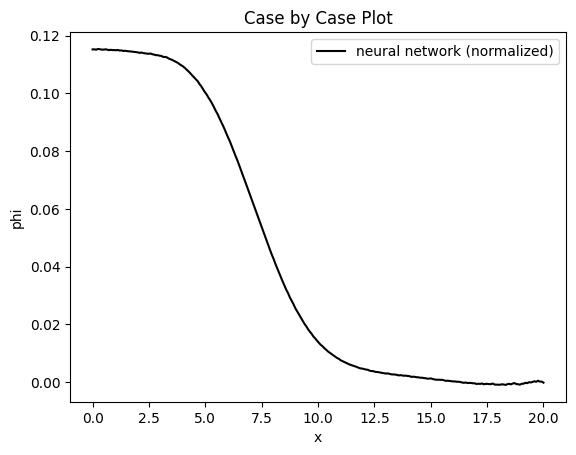

In [ ]:
#enter custom values
c = 1.1
t = 20
x0 = 12

#normalizing
ics_case = np.array([[t,x0,c]])
ics_case_norm = normalize(ics_case, 'l2')
ice_case_norm = ics_case_norm.transpose()

ycase = model.predict(ics_case_norm)

#plotting
import matplotlib.pyplot as plt

plt.figure(0)
plt.title("Case by Case Plot")
plt.plot(np.linspace(0, t, 250), ycase[0,:] , 'k-', label = "neural network (normalized)")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend(loc="best")
plt.show()
